In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PyPDF2 import PdfFileReader, PdfFileWriter
import os
from sklearn import preprocessing
import subprocess
import matplotlib.pyplot as plt
from itertools import islice
import re

In [2]:
%matplotlib inline

The general view of the pipeline looks something like this :- 

#### Feature Generation
1. Conversion of a pdf page image to components using RLSA. This basically runs from pixel to pixel and checks its surrounding if there is a `1` .i.e. if any pixel is black it will mark this pixel black. This will form block like structures that encapsulates the text region, lines etc. anything that is black.
2. For each block generate text using `pdftotext` this is a linux utility that exists. The only problem with this is it does not capture `-` dash at the moment, my guess is its mostly an option somewhere to be enabled.
3. Using the text information of each block, we run it through a few rules to cleanse the blocks, cleansing encapsulates the process of block separation at rows and columns level, removal based on the text that is present.


#### Marking Blocks
1. Based on the text values mark the `number cells` or as I like to call them `cell_values` .i.e. cell containing values of the sheet. This is generally simple to identifiy because of few attributes : -
    - Its comma separated numbers
    - Its generally followed by numbers or headers.
    - It forms a grid like structure, which we later on exploit to get mark other components around it.
2. Mark other blocks as cell headers and groupings based on these marked `cell_values` and how these are relatively positioned to the block.


#### Table Generation
Detect rows and go row by row to generate each row and parsing the text encapsulated in the row.

*Pasting functions from the older notebook for ease of use.*

In [3]:
def get_page_image_from_pdf(pdf, page_num, image_file_name):
    page_layout = pdf.getPage(page_num)['/MediaBox']
    command = "convert -density 300 '%s'[%s] '%s'" % (pdf_file_path,
                                                      page_num,
                                                      image_file_name)
    subprocess.check_output(command, shell=True)
    return cv2.imread(image_file_name, 0)

def rlsa(img, threshold):
    ret,thresh1 = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY_INV)
    img_iter = np.nditer(thresh1, flags=['multi_index'])
    C_vertical, C_horizontal = threshold
    temp_thresh = thresh1.copy()
    while not img_iter.finished:
        x, y = img_iter.multi_index
        x_threshold = x + C_horizontal
        y_threshold = y + C_vertical
        neg_x_threshold = x - C_horizontal
        neg_y_threshold = y - C_vertical
        if (thresh1[x:x_threshold, y:y_threshold].any() 
            or thresh1[x:x_threshold, y:neg_y_threshold].any()
            or thresh1[x:neg_x_threshold, y:y_threshold].any()
            or thresh1[x:neg_x_threshold, y:neg_y_threshold].any()):
            temp_thresh[x, y] = 1
        else:
            temp_thresh[x, y] = 0
        img_iter.iternext()
    return temp_thresh

def plot_page(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img, cmap='gray')

In [4]:
def get_label_stats(stats, centroids):
    stats_columns = ["left", "top", "width", "height", "area"]
    label_stats = pd.DataFrame(stats, columns=stats_columns)
    label_stats['centroid_x'], label_stats['centroid_y'] = centroids[:, 0], centroids[:, 1]
    # Ignore the label 0 since it is the background
    label_stats.drop(0, inplace=True)
    return label_stats

In [5]:
def get_possible_boundary_lines(label_stats):
    possible_boundary_lines = label_stats[(label_stats.width > 1200) & (label_stats.top > 0)]
    possible_boundary_lines['dist_from_next_line'] = possible_boundary_lines.top.shift(-1) - possible_boundary_lines.top
    possible_boundary_lines['dist_from_prev_line'] = possible_boundary_lines.top - possible_boundary_lines.top.shift(1)
    possible_boundary_lines.replace(pd.np.nan, pd.np.inf, inplace=True)
    return possible_boundary_lines[(possible_boundary_lines.dist_from_next_line > 100) & (possible_boundary_lines.dist_from_prev_line > 100)]

def draw_table_bounding_box(img, label_stats):
    possible_boundary_lines = get_possible_boundary_lines(label_stats).reset_index()
    waste_copy = img.copy()
    tables = []
    if len(possible_boundary_lines) % 2 != 0:
        raise "Uneven Probable Bounding Lines"
    for index, row in enumerate(possible_boundary_lines.iterrows()):
        if index % 2 != 0:
            table_bounds = {}
            top_bound = possible_boundary_lines.iloc[index - 1]
            bottom_bound = possible_boundary_lines.iloc[index]
            cv2.rectangle(waste_copy, (int(top_bound['left']), int(top_bound['top'])), 
                          (int(bottom_bound['right']) + 50, int(bottom_bound['bottom'])), (125,125,0), 5)
            table_bounds['left'], table_bounds['top'] = int(top_bound['left']), int(top_bound['top'])
            table_bounds['right'], table_bounds['bottom'] = int(bottom_bound['right']) + 50, int(bottom_bound['bottom'])
            tables.append(table_bounds)
    plot_page(waste_copy)
    return tables

def get_text(page_num, pdf_file_name, x, y, w, h):
    command = 'pdftotext -enc Windows-1255 -f {0} -l {0} -x {1} -y {2} -W {3} -H {4} "{5}" -'.format(page_num + 1,
                                                                                 int(x), 
                                                                                 int(y),
                                                                                 int(w),
                                                                                 int(h),
                                                                                 pdf_file_name)
    return subprocess.check_output(command, shell=True)

def get_text_data(row, page_num, pdf_file_path, horizontal_ratio, vertical_ratio):
    x = (row['left'] * horizontal_ratio)
    y = (row['top'] * vertical_ratio)
    width = (row['width'] * horizontal_ratio) + 5
    hieght = (row['height'] * vertical_ratio) + 5
    text = get_text(page_num, pdf_file_path, x, y, width, hieght)
    if len(text.strip().replace('-','')) < 1:
        row['text'] = text.strip().replace('-','')
    else:
        row['text'] = text.strip()
    row['text_length'] = len(row['text'])
    row['possible_row_merger'] = '\n' in row['text']
    text_matched = re.findall('[a-zA-Z_]+', row['text'])
    comma_sep_matcher = re.compile('^[1-9].(,[0-9]).*$')
    if comma_sep_matcher.match(row['text'].replace('\n', ' ')):
        row['comma_separated_numbers_present'] = True
    else:
        row['comma_separated_numbers_present'] = False
    if len(text_matched) > 0:
        row['is_text'] = True
    else:
        row['is_text'] = False
        
    try:
        row['number'] = int(row['text'].replace(',',''))
    except:
        row['number'] = None
    return row

def mark_number_cells(row):
    if (row['comma_separated_numbers_present'] and row['is_text'] is False) or (row['text'] == '...'):
        row['label'] = 'cell_values'
    return row


def mark_text_cells(row, labels):
    '''
    Detect cells below, left and right. Based on these cells make guesses of labels.
    '''
    left, right = row['left'], row['right']
    top, bottom = row['top'], row['bottom']
    if row['label'] != 'cell_values':      
        if (labels[(labels.right.between(right - 10, right + 10)) & 
                     (labels.top > top) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_header'
        elif (labels[(labels.top.between(top - 10, top + 10)) & 
                     (labels.left > left) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_grouping'
        elif (labels[(labels.bottom.between(bottom - 10, bottom + 10)) & 
                     (labels.left > left) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_grouping'
    return row
    

def get_possible_horizontal_lines(text_labels):
    possible_line_points = text_labels.bottom.value_counts()
    possible_line_points = possible_line_points[possible_line_points > 1]
    return possible_line_points.index


In [6]:
def mark_probable_headers(row, labels):
    left, top = row['left'], row['top']
    right, bottom = row['right'], row['bottom']
    labels = labels[labels.table == row['table']]
    # labels in a radius of 15
    x_pos_axis = labels[(labels.left.between(right - 10, right + 15)) &
                        (labels.label == 'cell_header')]
    x_neg_axis = labels[(labels.right.between(left - 15, left + 10)) &
                        (labels.label == 'cell_header')]
    y_pos_axis = labels[(labels.bottom.between(top - 20, top + 10)) &
                        (labels.label == 'cell_header')]
    y_neg_axis = labels[(labels.top.between(bottom - 10, bottom + 15)) &
                        (labels.label == 'cell_header')]

    if (len(x_pos_axis) + len(x_neg_axis) + len(y_pos_axis) + len(y_neg_axis)) > 0:
        if pd.isnull(row['label']):
            row['label'] = 'cell_header'
    return row

def find_higher_level_groupings(row, cell_grouping_height_range):
    bottom, label = row['bottom'], row['label']
    min_range, max_range = cell_grouping_height_range
    if (bottom > min_range) and (bottom < max_range) and (pd.isnull(label)):
        row['label'] = 'cell_higher_grouping'
    return row


In [7]:
def find_rows(labels):
    """
    Figure out the points where rows start and end.
    
    1. Headers would be the starting point. Bottom of the headers
    2. Each cell value will be separated by a row.
    """
    rows = []
    rows.extend(labels[labels['label'] == 'cell_header'].aggregate({'top': min, 'bottom': max}).values.flatten())
    rows.extend(labels[labels['label'] == 'cell_values']['bottom'].unique())
    filtered_rows = []
    for index, row_sep in enumerate(rows):
        if index > 0:
            last_row_sep = rows[index - 1]
            if row_sep > (last_row_sep + 20):
                filtered_rows.append(row_sep)
        else:
            filtered_rows.append(row_sep)
    return filtered_rows


def plot_horizontal_lines(line_ys, img, x_start, x_end):
    waste_copy2 = img.copy()
    for line_y in line_ys:
        line_starting_points = (int(x_start), int(line_y))
        line_stopping_points = (int(x_end), int(line_y))
        cv2.line(waste_copy2, line_starting_points, line_stopping_points, (125,255,0), 3)
    plot_page(waste_copy2)

def plot_vertical_lines(line_xs, img, y_start, y_end):
    waste_copy2 = img.copy()
    for line_x in line_xs:
        line_starting_points = (line_x, y_start)
        line_stopping_points = (line_x, y_end)
        cv2.line(waste_copy2, line_starting_points, line_stopping_points, (125,255,0), 3)
    plot_page(waste_copy2)
    
def find_common_headers(labels):
    unmarked_headers = labels[(labels.label == 'cell_header') & (pd.isnull(labels.header_index))]
    if len(unmarked_headers) > 0:
        header = unmarked_headers[unmarked_headers.top == unmarked_headers.top.min()]
        labels.ix[((labels.label == 'cell_header') & 
                   (labels.left.between(header.left.iloc[0] - header.width.iloc[0], header.right.iloc[0])) &
                   (pd.isnull(labels.header_index))
                  ), 'header_index'] = header.pos.iloc[0]
        return find_common_headers(labels)
    return labels
    
def cleanse_labels(labels):
    """
    We need to clean up labels to transform them into csv's
    
    1. Combine Headers so that they don't end up in new lines.
    2. Split label blocks with 2 values combined
    """
    processed_labels = pd.DataFrame()
    
    for index, row in labels.iterrows():
        splitted_row = []
        if row.possible_row_merger == True and  row.label != 'cell_header':
            for index, value in enumerate(row.text.split('\n')):
                new_row = {}
                for col in row.index:
                    new_row[col] = row[col]
                new_height = row.height // len(row.text.split('\n'))
                new_row['height'] = new_height
                new_row['top'] = row.top + (index * new_height)
                new_row['bottom'] = new_row['top'] + new_height
                new_row['text'] = value
                new_row['possible_row_merger'] = False
                splitted_row.append(new_row)
            processed_labels = processed_labels.append(splitted_row)
        else:
            processed_labels = processed_labels.append(row)
    return combine_horizontal(find_common_headers(processed_labels))


def combine_headers(labels):
    """
    1. Combine Blocks based on their horizontal distance.
    """
    processed_labels = pd.DataFrame()
    skip_pos = []
    for index, row in labels.iterrows():
        if row['pos'] not in skip_pos:
            nearby_header = labels[(labels.left.between(row['left'] - row['width'], row['right'])) &
                                   (labels.pos != row['pos']) &
                                   (labels.label == 'cell_header') &
                                   (labels.table == row['table'])].sort_values('top', ascending=True)
            if len(nearby_header) > 0 and row['label'] == 'cell_header':
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' ' + ' '.join(nearby_header.text.tolist())
                row['text'] = row['text'].replace('\n', ' ')
                row['width'] = row['width'] + nearby_header.width.sum()
                row['height'] = row['height'] + nearby_header.height.sum()
                row['left'] = min(row['left'], nearby_header.left.min())
                row['right'] = row['left'] + row['width']
                row['bottom'] = row['top'] + row['height']
                skip_pos.extend(nearby_header.pos.tolist())
            processed_labels = processed_labels.append(row)
    return processed_labels


def combine_horizontal(labels):
    """
    1. Combine Blocks based on their horizontal distance.
    """
    processed_labels = pd.DataFrame()
    skip_pos = []
    for index, row in labels.iterrows():
        if row['pos'] not in skip_pos:
            nearby_labels = labels[(labels.left.between(row['left'] - 5, row['right'] + 5)) &
                                   (labels.top.between(row['top'] -5, row['top'] + 5)) &
                                   (labels.pos != row['pos'])]
            if len(nearby_labels) > 0:
                # if mergable create a common label and push the `pos` of
                # the row that is being merged into skip_pos
                row['text'] = row['text'] + ' '.join(nearby_labels.text.tolist())
                row['width'] = row['width'] + nearby_labels.width.sum()
                row['right'] = row['left'] + row['width']
                skip_pos.extend(nearby_labels.pos.tolist())
            processed_labels = processed_labels.append(row)
    return processed_labels

        
def mark_titles(labels):
    labels.ix[((labels.is_text == True) & 
               (labels.centroid_x.between(1200, 1300)) &
               (pd.isnull(labels.label))
              ), 'label'] = 'title'
    return labels

def mark_summary(row):
    if row['is_text'] == True:
        summaries = re.findall("^[A-z, a-z]*\sRs. [0-9|,]*$", row['text'])
        if len(summaries) > 0:
            row['label'] = 'cell_summary'
    return row

def filter_out_footer(labels):
    bottom_boundary = labels[labels.label == 'cell_values']['bottom'].max()
    return labels[labels.top < bottom_boundary]

def mark_tables_using_titles(labels):
    titles = label_stats_with_text[label_stats_with_text.label == 'title']
    titles['next_diff'] = titles.top - titles.top.shift(1)
    seperators = titles[titles.next_diff > titles.next_diff.mean()]['top'].tolist()
    begin, end = labels.top.min(), labels.bottom.max()
    seperators = [begin] + seperators + [end]
    labels['table'] = None
    for index, sep in enumerate(seperators):
        if index > 0:
            table_start, table_end = seperators[index - 1], sep
            labels.loc[
                    labels['top'].between(table_start, table_end),
                    'table'
                ] = index
    return labels

def mark_rows(labels):
    for table in labels.table.unique():
        table_rows = labels[labels.table == table]
        rows = find_rows(table_rows)
        combined_rows = sorted(rows + table_rows[pd.isnull(table_rows.label)].bottom.unique().tolist())
        for index, row_start in enumerate(combined_rows[:-1]):
            row_end = combined_rows[index + 1]
            labels.loc[((labels.top.between(row_start, row_end)) & 
                        (labels.table == table)), 'row_index'] = index
    
    return labels
    

In [10]:
# Read PDF and page number
pdf_file_path = 'pdfs/west bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'
pdf = PdfFileReader(open(pdf_file_path, 'rb'))
page_layout = pdf.getPage(3)['/MediaBox']
if '/Rotate' in pdf.getPage(3) and pdf.getPage(3)['/Rotate'] == 90:
    page_width = float(page_layout[3])
    page_height = float(page_layout[2])
else:
    page_width = float(page_layout[2])
    page_height = float(page_layout[3])
img_page = get_page_image_from_pdf(pdf, 2, 'west_bengal_demand_1_5_page_1.png')
image_height, image_width = img_page.shape
horizontal_ratio = page_width / image_width
vertical_ratio = page_height / image_height
# Convert to components
img_rlsa = rlsa(img_page, (20, 25))
# extract geometrical features
n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(img_rlsa)
label_stats = get_label_stats(stats, centroids)
label_stats['right'] = label_stats.left + label_stats.width
label_stats['bottom'] = label_stats.top + label_stats.height

In [11]:
# extract text based features and some basic cleaning
label_stats_with_text = label_stats.apply(get_text_data, axis=1, args=[2, pdf_file_path, horizontal_ratio, vertical_ratio])


In [12]:
# Mark All components as Text and Number
label_stats_with_text = label_stats_with_text[label_stats_with_text.text_length > 0].apply(mark_number_cells, axis=1)
label_stats_with_text = label_stats_with_text.apply(mark_text_cells, axis=1, args=[label_stats_with_text])
# Set some required columns that will be set later on.
label_stats_with_text['header_index'] = None
label_stats_with_text['pos'] = label_stats_with_text.index
# Clean up labels
label_stats_with_text = cleanse_labels(label_stats_with_text)
# Mark summaries, titles
# label_stats_with_text = mark_probable_headers(label_stats_with_text)
label_stats_with_text = mark_titles(label_stats_with_text)
label_stats_with_text = label_stats_with_text.apply(mark_summary, axis=1)
# Filter out excessive information
label_stats_with_text = filter_out_footer(label_stats_with_text)
label_stats_with_text

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated [ipykernel_launcher.py:45]
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated [ipykernel_launcher.py:131]


,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,header_index,height,is_text,label,left,number,pos,possible_row_merger,right,text,text_length,top,width
4,42076.0,165.0,1229.127793,133.112392,0.0,NaN,62.0,1.0,title,885.0,NaN,4.0,0.0,1575.0,REVENUE EXPENDITURE,19.0,103.0,690.0
6,19420.0,234.0,1225.853708,205.540783,0.0,NaN,57.0,1.0,title,1049.0,NaN,6.0,0.0,1409.0,DEMAND No. 01,13.0,177.0,360.0
8,34215.0,312.0,1225.751308,277.009908,0.0,NaN,66.0,1.0,title,901.0,NaN,8.0,0.0,1559.0,Legislative Assembly Secretariat,32.0,246.0,658.0
10,41069.0,381.0,1232.540627,346.063040,0.0,NaN,66.0,1.0,title,827.0,NaN,10.0,0.0,1632.0,A-General Services - (a) Organs of State,40.0,315.0,805.0
12,44366.0,449.0,1228.446445,413.491277,0.0,NaN,66.0,1.0,title,798.0,NaN,12.0,0.0,1662.0,Head of Account : 2011 - State Legislatures,43.0,383.0,864.0
14,25409.0,567.0,379.711559,531.492739,0.0,NaN,65.0,1.0,cell_summary,142.0,NaN,14.0,0.0,604.0,"Voted Rs. 61,50,66,000",22.0,502.0,462.0
15,24421.0,568.0,1242.827566,532.310348,0.0,NaN,66.0,1.0,cell_summary,1016.0,NaN,15.0,0.0,1462.0,"Charged Rs. 59,10,000",21.0,502.0,446.0
16,24894.0,567.0,2098.311762,531.411304,0.0,16.0,65.0,1.0,cell_summary,1869.0,NaN,16.0,0.0,2317.0,"Total Rs. 62,09,76,000",22.0,502.0,448.0
20,9843.0,679.0,1933.956416,648.331505,0.0,16.0,59.0,1.0,cell_header,1833.0,NaN,20.0,0.0,2039.0,Charged Rs.,11.0,620.0,206.0
21,8152.0,672.0,1678.513494,646.764475,0.0,16.0,51.0,1.0,cell_header,1593.0,NaN,21.0,0.0,1767.0,Voted Rs.,9.0,621.0,174.0


In [13]:
# Separate out Tables and find rows and columns
label_stats_with_text = mark_tables_using_titles(label_stats_with_text)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:147]


In [14]:
label_stats_with_text = combine_headers(label_stats_with_text.apply(mark_probable_headers, args=[label_stats_with_text], axis=1))

In [15]:
# Separate out Tables and find rows.
rows = []
for table_no in label_stats_with_text.table.unique().tolist():
    temp_rows = find_rows(label_stats_with_text[label_stats_with_text.table == table_no])
    print(temp_rows)
    rows.extend(temp_rows)


[620.0, 679.0, 789.0, 845.0, 840.0, 959.0]
[1202.0, 1418.0, 1651.0, 1706.0, 1821.0, 2001.0, 2056.0, 2171.0, 2296.0, 2407.0, 2462.0, 2578.0, 2688.0, 2743.0]


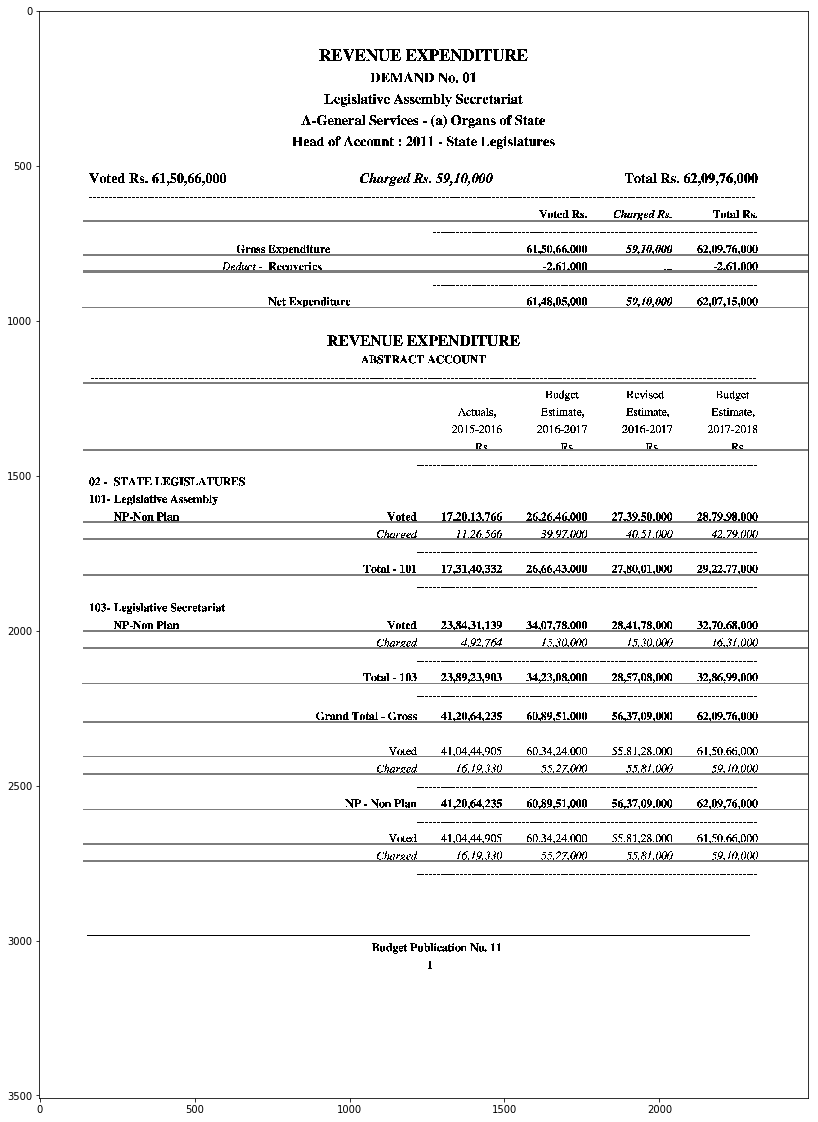

In [16]:
plot_horizontal_lines(rows[1:], img_page, label_stats_with_text.left.min(), label_stats_with_text.right.max())

Before start processing each row we need to handle some of the components/labels that are still marked as `NaN`.
At the moment I am just giving each one of them a separate row.

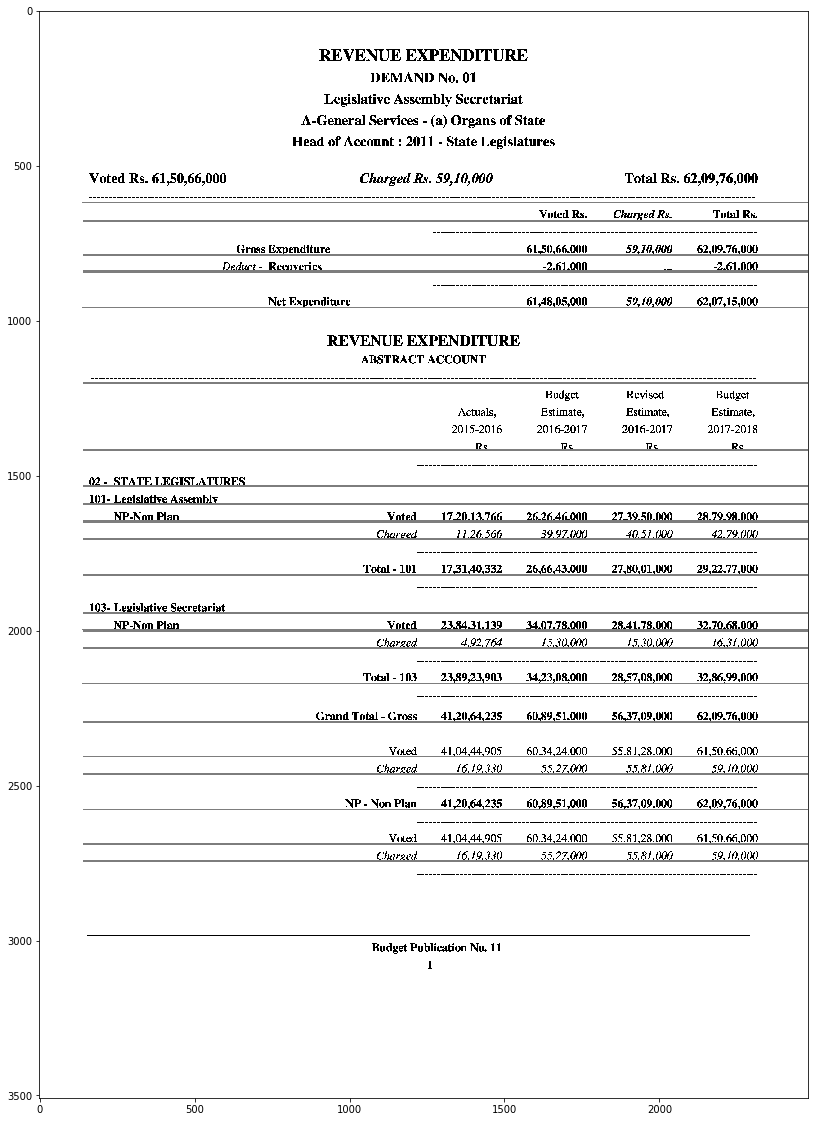

In [17]:
combined_rows = rows + label_stats_with_text[pd.isnull(label_stats_with_text.label)].bottom.unique().tolist()
plot_horizontal_lines(combined_rows, img_page, label_stats_with_text.left.min(), label_stats_with_text.right.max())

In [18]:
mark_rows(label_stats_with_text).groupby(['table', 'row_index']).apply(lambda x: len(sorted(x['left'].unique())))

table  row_index
1.0    0.0          3
       1.0          4
       2.0          4
       4.0          4
2.0    0.0          4
       1.0          1
       2.0          1
       3.0          6
       5.0          5
       6.0          5
       7.0          1
       8.0          6
       10.0         5
       11.0         5
       12.0         5
       13.0         5
       14.0         5
       15.0         5
       16.0         5
       17.0         5
dtype: int64

In [19]:
mark_rows(label_stats_with_text).groupby(['table', 'row_index']).apply(lambda x: len(sorted(x['left'].unique()))).idxmax()

(2.0, 3.0)

In [20]:
mark_rows(label_stats_with_text).groupby(['table', 'row_index']).apply(lambda x: sorted(x['right'].unique()))

table  row_index
1.0    0.0                                 [1767.0, 2039.0, 2316.0]
       1.0                          [938.0, 1767.0, 2042.0, 2317.0]
       2.0                          [909.0, 1767.0, 2039.0, 2317.0]
       4.0                         [1004.0, 1767.0, 2042.0, 2317.0]
2.0    0.0                         [1557.0, 1958.0, 2247.0, 2510.0]
       1.0                                                  [660.0]
       2.0                                                  [577.0]
       3.0          [577.0, 1217.0, 1494.0, 1768.0, 2043.0, 2318.0]
       5.0                 [1219.0, 1494.0, 1768.0, 2043.0, 2318.0]
       6.0                 [1216.0, 1492.0, 1767.0, 2042.0, 2317.0]
       7.0                                                  [601.0]
       8.0          [601.0, 1217.0, 1492.0, 1768.0, 2043.0, 2318.0]
       10.0                [1219.0, 1492.0, 1768.0, 2043.0, 2318.0]
       11.0                [1217.0, 1492.0, 1767.0, 2042.0, 2317.0]
       12.0                [121

In [21]:
def filter_possible_cols(cols, img, table_start, table_end):
    columns_df = pd.DataFrame({'cols': cols})
    columns_df['dark_pixel_count'] = columns_df.cols.apply(lambda x: (img[table_start:table_end, int(x)] < 255).sum())
    columns_df['next_diff'] = columns_df.cols.shift(-1) - columns_df.cols
    filtered_columns_df = columns_df[columns_df['dark_pixel_count'] < 50]
    return filtered_columns_df

def find_columns(labels_with_rows):
    for table in labels_with_rows.table.unique():
        table_rows = labels_with_rows[labels_with_rows.table == table]
        row_with_max_cols = table_rows.groupby(['row_index']).apply(lambda x: len(sorted(x['right'].unique()))).idxmax()
        possible_cols = table_rows.groupby(['row_index']).apply(lambda x: sorted(x['right'].unique())).loc[row_with_max_cols]
        table_start, table_end = table_rows.agg({'top':min, 'bottom': max}).values.flatten()
        cols = filter_possible_cols(possible_cols, img_page, int(table_start), int(table_end))
        table_start, table_end = table_rows.left.min(), table_rows.right.max()
        table_cols = [table_start] + sorted(possible_cols) + [table_end]
        print(table_cols)
        for index, col_start in enumerate(table_cols[:-1]):
            col_end = table_cols[index + 1]
            labels_with_rows.loc[(labels_with_rows.left.between(col_start, col_end) & 
                                 (labels_with_rows.table == table)), 'col_index'] = index
        
    return labels_with_rows


def mark_rows_and_cols(labels):
    labels_with_rows = mark_rows(label_stats_with_text)
    return find_columns(labels_with_rows)


In [22]:
label_stats_with_row_col = mark_rows_and_cols(label_stats_with_text)

[142.0, 938.0, 1767.0, 2042.0, 2317.0, 2317.0]
[143.0, 577.0, 1217.0, 1494.0, 1768.0, 2043.0, 2318.0, 2510.0]


In [23]:
table_one = label_stats_with_row_col[(label_stats_with_row_col.table == 1) &
                                     (pd.notnull(label_stats_with_row_col.row_index))]

In [24]:
for _, group in table_one.sort_values('top').groupby('row_index'):
    print(group.sort_values('left').text.values)
    print(group.sort_values('left').col_index.values)

['Voted Rs.' 'Charged Rs.' 'Total Rs.']
[ 1.  2.  3.]
['Gross Expenditure' '61,50,66,000' '59,10,000' '62,09,76,000']
[ 0.  1.  2.  3.]
['Deduct -Recoveries' '-2,61,000' '...' '-2,61,000']
[ 0.  1.  2.  3.]
['Net Expenditure' '61,48,05,000' '59,10,000' '62,07,15,000']
[ 0.  1.  2.  3.]


In [25]:
table_two = label_stats_with_row_col[(label_stats_with_row_col.table == 2) &
                                     (pd.notnull(label_stats_with_row_col.row_index))]
for _, group in table_two.sort_values('top').groupby('row_index'):
    print(group.sort_values('left').text.values)
    print(group.sort_values('left').col_index.values)

['Actuals, 2015-2016 Rs.' 'Budget Estimate, 2016-2017 Rs.'
 'Revised Estimate, 2016-2017 Rs.' 'Budget Estimate, 2017-2018 Rs.']
[ 2.  3.  4.  5.]
['02 -STATE LEGISLATURES']
[ 0.]
['101- Legislative Assembly']
[ 0.]
['NP-Non Plan' 'Voted' '17,20,13,766' '26,26,46,000' '27,39,50,000'
 '28,79,98,000']
[ 0.  1.  2.  3.  4.  5.]
['Charged' '11,26,566' '39,97,000' '40,51,000' '42,79,000']
[ 1.  2.  3.  4.  5.]
['Total - 101' '17,31,40,332' '26,66,43,000' '27,80,01,000' '29,22,77,000']
[ 1.  2.  3.  4.  5.]
['103- Legislative Secretariat']
[ 0.]
['NP-Non Plan' 'Voted' '23,84,31,139' '34,07,78,000' '28,41,78,000'
 '32,70,68,000']
[ 0.  1.  2.  3.  4.  5.]
['Charged' '4,92,764' '15,30,000' '15,30,000' '16,31,000']
[ 1.  2.  3.  4.  5.]
['Total - 103' '23,89,23,903' '34,23,08,000' '28,57,08,000' '32,86,99,000']
[ 1.  2.  3.  4.  5.]
['Grand Total - Gross' '41,20,64,235' '60,89,51,000' '56,37,09,000'
 '62,09,76,000']
[ 1.  2.  3.  4.  5.]
['Voted' '41,04,44,905' '60,34,24,000' '55,81,28,000' '61,

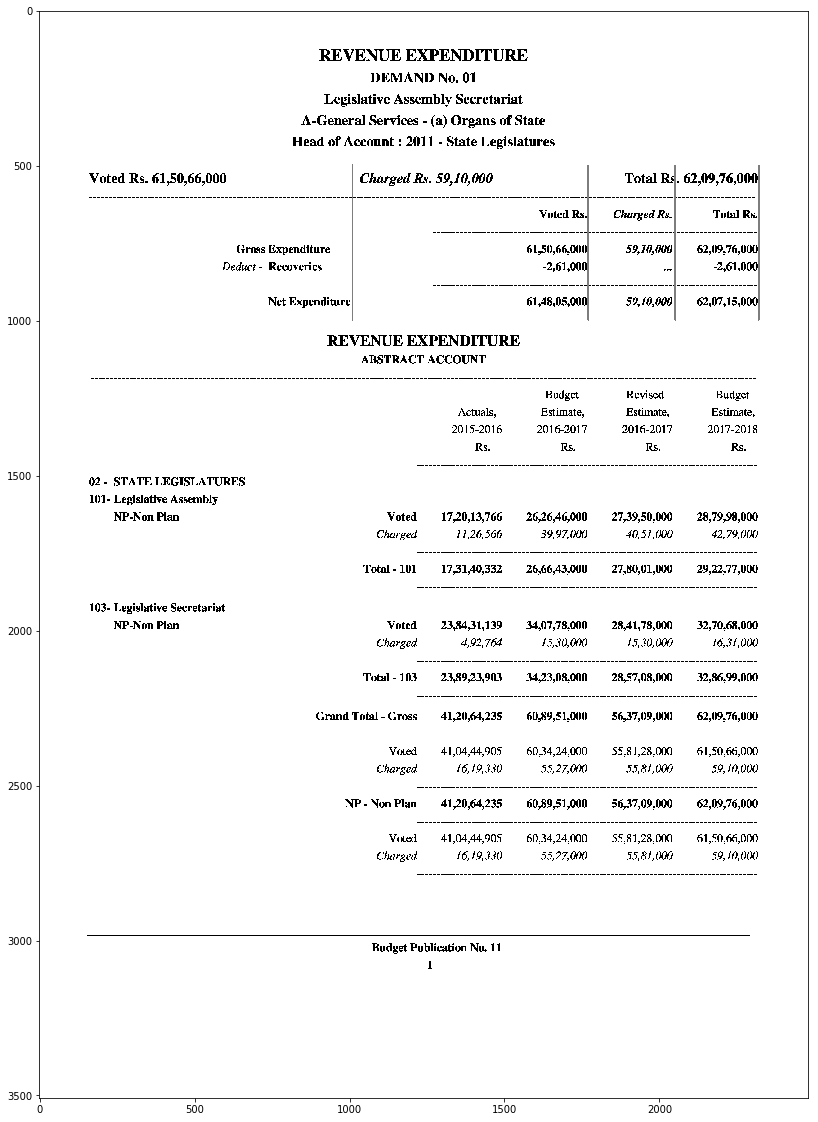

In [26]:
plot_vertical_lines([1010, 1770, 2050, 2320], img_page, 500, 1000)

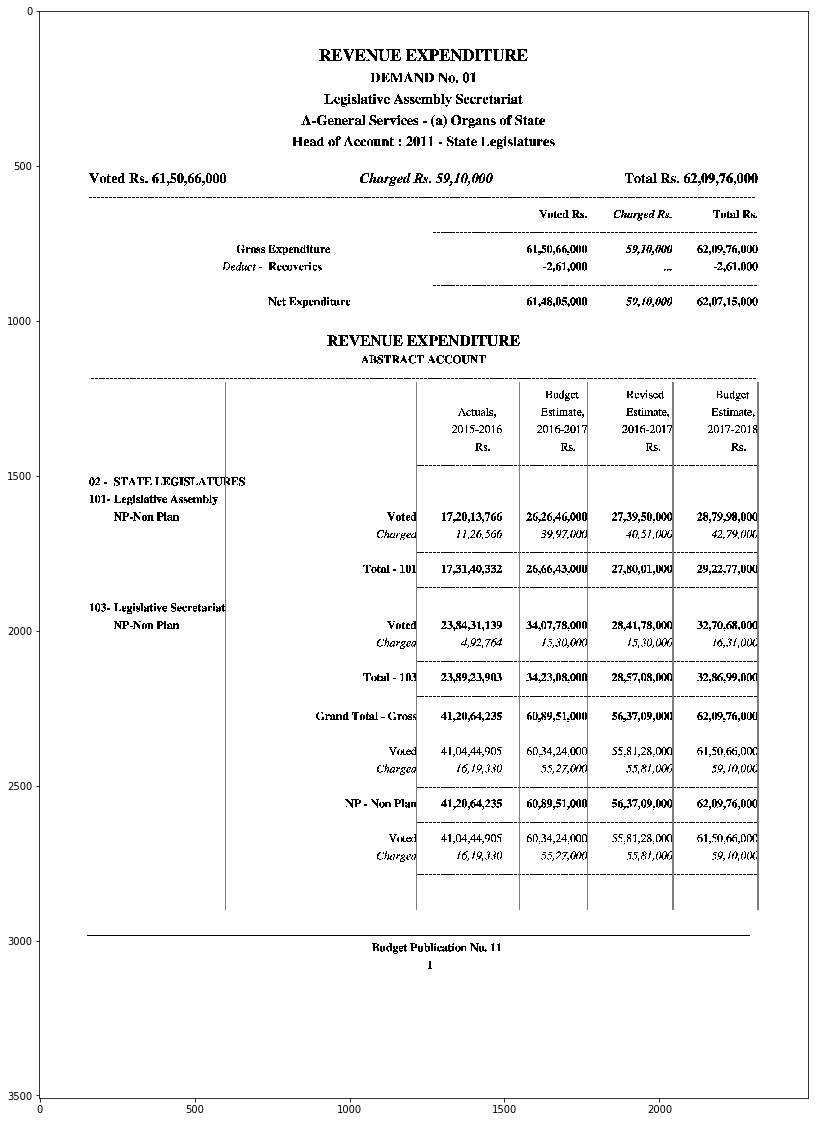

In [27]:
plot_vertical_lines([600, 1217, 1549, 1768, 2043, 2318], img_page, 1200, 2900)

### Convert to csv

In [28]:
for table_no in label_stats_with_row_col.table.unique():
    table_labels = label_stats_with_row_col[label_stats_with_row_col.table == table_no]
    title = '_'.join(table_labels[table_labels.label == 'title']['text'].tolist()).replace(' ', '_')
    filename = title + '.csv'
    max_col = int(table_labels.col_index.max())
    with open(filename, 'w') as csv_file:
        # for each row write a line
        for _, group in table_labels.sort_values('top').groupby('row_index'):
            row = ''
            for column_index in range(max_col):
                value = group[group.col_index == column_index]
                if len(value.index) == 0:
                    row += ' ;'
                else:
                    row += value.text.iloc[0] + ';'
            csv_file.write(row)
            csv_file.write('\n')
            print(row)

 ;Voted Rs.;Charged Rs.;
Gross Expenditure;61,50,66,000;59,10,000;
Deduct -Recoveries;-2,61,000;...;
Net Expenditure;61,48,05,000;59,10,000;
 ; ;Actuals, 2015-2016 Rs.;Budget Estimate, 2016-2017 Rs.;Revised Estimate, 2016-2017 Rs.;
02 -STATE LEGISLATURES; ; ; ; ;
101- Legislative Assembly; ; ; ; ;
NP-Non Plan;Voted;17,20,13,766;26,26,46,000;27,39,50,000;
 ;Charged;11,26,566;39,97,000;40,51,000;
 ;Total - 101;17,31,40,332;26,66,43,000;27,80,01,000;
103- Legislative Secretariat; ; ; ; ;
NP-Non Plan;Voted;23,84,31,139;34,07,78,000;28,41,78,000;
 ;Charged;4,92,764;15,30,000;15,30,000;
 ;Total - 103;23,89,23,903;34,23,08,000;28,57,08,000;
 ;Grand Total - Gross;41,20,64,235;60,89,51,000;56,37,09,000;
 ;Voted;41,04,44,905;60,34,24,000;55,81,28,000;
 ;Charged;16,19,330;55,27,000;55,81,000;
 ;NP - Non Plan;41,20,64,235;60,89,51,000;56,37,09,000;
 ;Voted;41,04,44,905;60,34,24,000;55,81,28,000;
 ;Charged;16,19,330;55,27,000;55,81,000;


In [33]:
!ls

'Block detection Sample generation.ipynb'
 cbga_parsers
'Command generation.ipynb'
 current_method_table_boundary.png
'horizontal boundaries blob detection.png'
 karnataka
 man-bash.pdf
 measure_sample.csv
 odisha
 page4_tags.csv
 parsers
 pdf_explorer.py
 pdfs
'PDF to CSV Block Method Pipeline.ipynb'
'PDF To CSV Pipeline - Combining the blocks.ipynb'
 perf_monit.log
 python2_cbga_parsers
 REVENUE_EXPENDITURE_ABSTRACT_ACCOUNT.csv
'REVENUE_EXPENDITURE_DEMAND_No._01_Legislative_Assembly_Secretariat_A-General_Services_-_(a)_Organs_of_State_Head_of_Account_:_2011_-_State_Legislatures.csv'
'REVENUE_EXPENDITURE_DEMAND_No._01_Legislative_Assembly_Secretariat_AGeneral_Services__(a)_Organs_of_State_Head_of_Account_:_2011__State_Legislatures.csv'
 sample.csv
 sample.png
 sample_text_labels.csv
 sample_workflow.png
 test.txt
 wb_parsed_files.csv
 wb_sample
 west_bengal_demand_1_5_page_1.png
 west_bengal_parsed_pdf


In [36]:
pd.read_csv('REVENUE_EXPENDITURE_ABSTRACT_ACCOUNT.csv')

ParserError: Error tokenizing data. C error: Expected 4 fields in line 4, saw 10
